In [172]:
#Smart Grid Energy Distribution using Genetic Algorithms and Parallel Computing
import numpy as np
import random
import time
import multiprocessing
import matplotlib.pyplot as plt
import threading
import psutil

In [173]:

#  System Monitoring
# Global variables for monitoring
cpu_usage_data_monitor = []
monitoring_flag = False
start_time_monitor = None


def plot_cpu_usage_comparison(serial_time, parallel_time):
    global cpu_usage_data_monitor, start_time_monitor

    if not cpu_usage_data_monitor:
        print("No CPU usage data collected")
        return
    if serial_time is None or parallel_time is None:
         print("Execution times not provided for CPU usage plot.")
         return

    plt.figure(figsize=(12, 6))



    #  Visualization
    print("\ Generating Plots")
    try:
       plot_convergence_curves(serial_history, parallel_history)
    except Exception as e:
       print(f"Error plotting convergence curves: {e}")

    try:
       plot_execution_time_comparison(serial_time, parallel_time)
    except Exception as e:
       print(f"Error plotting execution time comparison: {e}")

    try:
       compare_all_methods(baseline_fitness, best_fit_serial, best_fit_parallel)
    except Exception as e:
       print(f"Error plotting all methods comparison: {e}")

    try:
       plot_cpu_usage_comparison(serial_time, parallel_time)
    except Exception as e:
       print(f"Error plotting CPU usage comparison: {e}")

    # Stop monitoring
    stop_monitoring()
    monitor_thread.join()


In [174]:
def monitor_system_usage():
    """Monitor CPU usage during execution"""
    global cpu_usage_data_monitor, monitoring_flag, start_time_monitor
    cpu_usage_data_monitor = []
    start_time_monitor = time.time()
    while monitoring_flag:
        cpu_percent = psutil.cpu_percent(interval=0.1)
        cpu_usage_data_monitor.append(cpu_percent)

In [175]:
def start_monitoring():
    """Start system monitoring in a separate thread"""
    global monitoring_flag
    monitoring_flag = True
    monitor_thread = threading.Thread(target=monitor_system_usage, daemon=True)
    monitor_thread.start()
    return monitor_thread

In [176]:
def stop_monitoring():
    """Stop system monitoring"""
    global monitoring_flag
    monitoring_flag = False

#  Start Monitoring Early
monitor_thread = start_monitoring()

In [177]:

#  Problem Definition and Parameters
# Fixing seed for reproducibility
np.random.seed(42)
number_of_nodes = 10
number_of_sources = 2
number_of_timeslots = 24

In [178]:


# Demand per node at each time slot with random integers between 5 and 20
demand_per_node_timeslot = np.random.randint(5, 20, size=(number_of_nodes, number_of_timeslots))

# Capacity per source at each time slot with random integers between 30 and 60
capacity_per_source_timeslot = np.random.randint(30, 60, size=(number_of_sources, number_of_timeslots))

# Cost per unit energy from source to node having float values between 0.5 and 2.5
cost_source_node = np.round(np.random.uniform(0.5, 2.5, size=(number_of_sources, number_of_nodes)), 2)

# Transmission loss percentage having float values between 5% to 15%
loss_source_node = np.round(np.random.uniform(0.05, 0.15, size=(number_of_sources, number_of_nodes)), 2)

# Peak hours indicator (1 if peak and 0 if not). Assuming 5 PM to 8 PM is peak
peak_hours_indicator = np.zeros(number_of_timeslots)
peak_hours_indicator[17:21] = 1  # Peak from 5 PM to 8 PM

# Penalty weights
COST_WEIGHT = 1.0
CAPACITY_PENALTY_WEIGHT = 26
DEMAND_PENALTY_WEIGHT = 15
PEAK_PENALTY_WEIGHT = 10


In [179]:
#  Fitness Calculation Functions
def compute_total_cost(chromosome):
    total_cost = 0
    chromosome = chromosome.reshape(number_of_sources, number_of_nodes, number_of_timeslots)
    for t in range(number_of_timeslots):
        for s in range(number_of_sources):
            for n in range(number_of_nodes):
                energy_sent = chromosome[s, n, t]
                effective_cost = energy_sent * cost_source_node[s, n] * (1 + loss_source_node[s, n])
                total_cost += effective_cost
    return total_cost

In [180]:
def compute_capacity_penalties(chromosome):
    total_penalty = 0
    chromosome = chromosome.reshape(number_of_sources, number_of_nodes, number_of_timeslots)
    for t in range(number_of_timeslots):
        for s in range(number_of_sources):
            energy_sent_by_source = np.sum(chromosome[s, :, t])
            if energy_sent_by_source > capacity_per_source_timeslot[s, t]:
                total_penalty += (energy_sent_by_source - capacity_per_source_timeslot[s, t]) * CAPACITY_PENALTY_WEIGHT
    return total_penalty

In [181]:

def compute_demand_penalties(chromosome):
    total_penalty = 0
    chromosome = chromosome.reshape(number_of_sources, number_of_nodes, number_of_timeslots)
    for t in range(number_of_timeslots):
        for n in range(number_of_nodes):
            energy_received = np.sum(chromosome[:, n, t])
            demand = demand_per_node_timeslot[n, t]
            total_penalty += abs(demand - energy_received) * DEMAND_PENALTY_WEIGHT
    return total_penalty

In [182]:
def compute_peak_hour_penalties(chromosome):
    total_penalty = 0
    chromosome = chromosome.reshape(number_of_sources, number_of_nodes, number_of_timeslots)
    for t in range(number_of_timeslots):
        if peak_hours_indicator[t] == 1:
            total_energy = np.sum(chromosome[:, :, t])
            peak_limit = 100  # Example threshold
            if total_energy > peak_limit:
                total_penalty += (total_energy - peak_limit) * PEAK_PENALTY_WEIGHT
    return total_penalty

In [183]:
def fitness_function(chromosome_flat):
    # Calculating individual components
  total_cost = compute_total_cost(chromosome_flat)
  capacity_penalty = compute_capacity_penalties(chromosome_flat)
  demand_penalty = compute_demand_penalties(chromosome_flat)
  peak_penalty = compute_peak_hour_penalties(chromosome_flat)
    # Combines all components
  fitness_value = total_cost + capacity_penalty + demand_penalty + peak_penalty
  return fitness_value


In [184]:
#  Genetic Algorithm Helper Functions
def initialize_population(pop_size):
    population = []
    for _ in range(pop_size):
        chromo = np.zeros((number_of_sources, number_of_nodes, number_of_timeslots))
        for t in range(number_of_timeslots):
            for s in range(number_of_sources):
                for n in range(number_of_nodes):
                    # Limit random allocation by min of capacity and demand
                    max_energy = min(capacity_per_source_timeslot[s, t], demand_per_node_timeslot[n, t])
                    chromo[s, n, t] = np.random.uniform(0, max_energy)
        population.append(chromo.flatten())
    return population

In [185]:
def select_parents(population, fitness_values, k=3):
    selected = []
    for _ in range(2):
        aspirants_idx = random.sample(range(len(population)), k)
        aspirants = [(fitness_values[i], population[i]) for i in aspirants_idx]
        winner = min(aspirants, key=lambda x: x[0])
        selected.append(winner[1])
    return selected


In [186]:
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 2)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

In [187]:
def mutate(chromosome, mutation_rate=0.1):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            # Mutating gene by up to 10% of current value
            mutation_value = chromosome[i] * 0.1 * (random.random() - 0.5) * 2
            chromosome[i] += mutation_value
            if chromosome[i] < 0:
                chromosome[i] = 0
    return chromosome

In [188]:
#  Baseline Method
def greedy_allocation():
    allocation = np.zeros((number_of_sources, number_of_nodes, number_of_timeslots))
    for t in range(number_of_timeslots):
        for n in range(number_of_nodes):
            remaining_demand = demand_per_node_timeslot[n, t]
            # Sorting sources by cost for this node (cheapest first)
            sorted_sources = sorted(range(number_of_sources), key=lambda x: cost_source_node[x, n])
            for s in sorted_sources:
                if remaining_demand <= 0:
                    break
                # Allocation of maximum possible energy without exceeding capacity
                alloc = min(remaining_demand, capacity_per_source_timeslot[s, t])
                allocation[s, n, t] = alloc
                remaining_demand -= alloc
    return allocation.flatten()

In [189]:
#  Main Genetic Algorithm Functions
def genetic_algorithm_serial(pop_size=50, max_generations=50):
    population = initialize_population(pop_size)
    best_fitness = float('inf')
    best_solution = None
    generation = 0
    # For logging best fitness per generation
    best_fitness_history = []
    # Loop for a set number of generations:
    while generation < max_generations:
        # Evaluate fitness for all chromosomes in population
        start_fit = time.time()
        fitness_values = [fitness_function(individual) for individual in population]
        end_fit = time.time()
        print(f"[Serial] Fitness evaluation time (Gen {generation}): {end_fit - start_fit:.4f} sec")

        # Finding best chromosome in current generation
        gen_best_idx = np.argmin(fitness_values)
        gen_best_fitness = fitness_values[gen_best_idx]

        # Storing the best fitness for this generation
        best_fitness_history.append(gen_best_fitness)

        # Updates global best if current best is better
        if gen_best_fitness < best_fitness:
            best_fitness = gen_best_fitness
            best_solution = population[gen_best_idx]
        print(f"Generation {generation} best fitness: {gen_best_fitness:.2f}")

        new_population = []  # Create new generation using selection, crossover and mutation
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_values)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])

        # Trims new population if it exceeds population size
        population = new_population[:pop_size]
        generation += 1

    return best_solution, best_fitness, best_fitness_history

In [190]:

def genetic_algorithm_parallel(pop_size=50, max_generations=50):

    population = initialize_population(pop_size)
    best_fitness = float('inf')
    best_solution = None

    pool = multiprocessing.Pool()  # Create pool for parallel processing

    # For logging best fitness per generation
    best_fitness_history = []
    generation = 0
    try:
        while generation < max_generations:
            # Parallel fitness evaluation across the population
            start_fit = time.time()
            fitness_values = pool.map(fitness_function, population)
            end_fit = time.time()
            print(f"[Parallel] Fitness evaluation time (Gen {generation}): {end_fit - start_fit:.4f} sec")

            # Finding best chromosome in current generation
            gen_best_idx = np.argmin(fitness_values)
            gen_best_fitness = fitness_values[gen_best_idx]

            # Storing best fitness for this generation
            best_fitness_history.append(gen_best_fitness)

            # Updating global best if current best is better
            if gen_best_fitness < best_fitness:
                best_fitness = gen_best_fitness
                best_solution = population[gen_best_idx]
            print(f"[Parallel] Generation {generation} best fitness: {gen_best_fitness:.2f}")

            new_population = []  # Creating new generation using selection, crossover and mutation
            while len(new_population) < pop_size:
                parent1, parent2 = select_parents(population, fitness_values)
                child1, child2 = crossover(parent1, parent2)
                child1 = mutate(child1)
                child2 = mutate(child2)
                new_population.extend([child1, child2])
            population = new_population[:pop_size]
            generation += 1
    finally:
        pool.close()
        pool.join()
    return best_solution, best_fitness, best_fitness_history

In [195]:
#  Main Execution
if __name__ == "__main__":
    # Baseline method
    print( "Running Baseline Method")
    baseline_solution = greedy_allocation()
    baseline_fitness = fitness_function(baseline_solution)
    print(f"Baseline (Greedy) Fitness Score: {baseline_fitness:.2f}")

    # Serial GA
    print("\ Running Serial Genetic Algorithm")
    start = time.time()
    best_sol_serial, best_fit_serial, serial_history = genetic_algorithm_serial(pop_size=50, max_generations=50)
    serial_time = time.time() - start
    print(f"Serial GA took {serial_time:.2f} seconds")
    print(f"Serial GA Best Fitness: {best_fit_serial:.2f}")
    print(f"Serial GA History length: {len(serial_history)}")

    # Parallel GA
    print("\ Running Parallel Genetic Algorithm")
    start = time.time()
    best_sol_parallel, best_fit_parallel, parallel_history = genetic_algorithm_parallel(pop_size=50, max_generations=50)
    parallel_time = time.time() - start
    print(f"Parallel GA took {parallel_time:.2f} seconds")
    print(f"Parallel GA Best Fitness: {best_fit_parallel:.2f}")
    print(f"Parallel GA History length: {len(parallel_history)}")

Running Baseline Method
Baseline (Greedy) Fitness Score: 28784.33
\ Running Serial Genetic Algorithm
[Serial] Fitness evaluation time (Gen 0): 0.0998 sec
Generation 0 best fitness: 39408.23
[Serial] Fitness evaluation time (Gen 1): 0.0965 sec
Generation 1 best fitness: 39947.85
[Serial] Fitness evaluation time (Gen 2): 0.0920 sec
Generation 2 best fitness: 38227.34
[Serial] Fitness evaluation time (Gen 3): 0.1111 sec
Generation 3 best fitness: 38000.07
[Serial] Fitness evaluation time (Gen 4): 0.1429 sec
Generation 4 best fitness: 37243.58
[Serial] Fitness evaluation time (Gen 5): 0.0948 sec
Generation 5 best fitness: 35414.70
[Serial] Fitness evaluation time (Gen 6): 0.0955 sec
Generation 6 best fitness: 36503.90
[Serial] Fitness evaluation time (Gen 7): 0.1041 sec
Generation 7 best fitness: 35873.89
[Serial] Fitness evaluation time (Gen 8): 0.1028 sec
Generation 8 best fitness: 35006.97
[Serial] Fitness evaluation time (Gen 9): 0.0938 sec
Generation 9 best fitness: 34279.17
[Serial] 

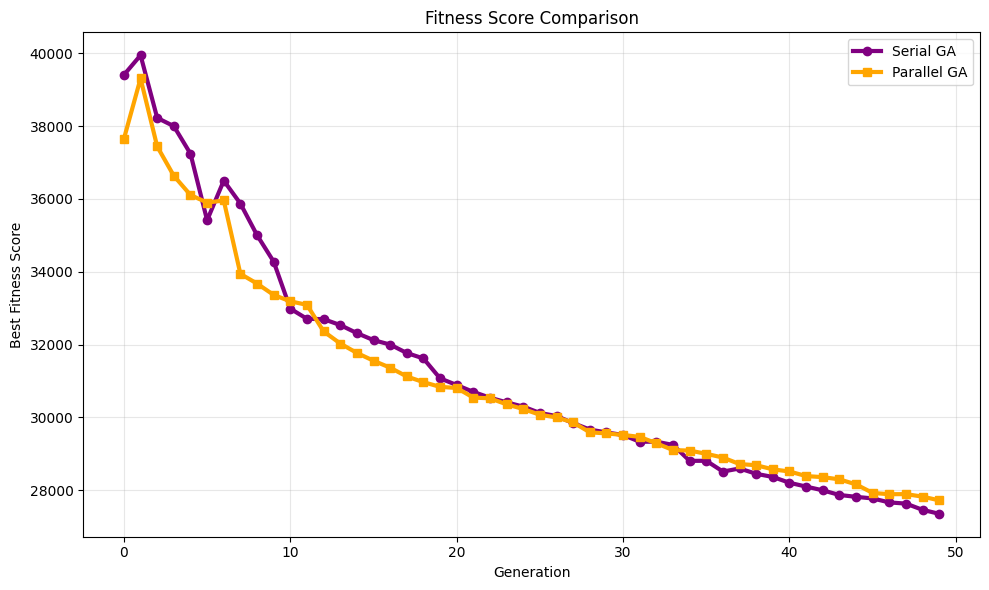

In [213]:
#  Visualization Functions
def plot_convergence_curves(serial_history, parallel_history):
    if not serial_history or not parallel_history:
        print("No history data to plot.")
        return
    plt.figure(figsize=(10, 6))
    # Ensure both histories have the same length by padding with last value
    max_len = max(len(serial_history), len(parallel_history))
    # Pad shorter history with its last value
    serial_padded = list(serial_history) + [serial_history[-1]] * (max_len - len(serial_history))
    parallel_padded = list(parallel_history) + [parallel_history[-1]] * (max_len - len(parallel_history))

    generations = range(max_len)
    plt.plot(generations, serial_padded, label='Serial GA', marker='o', linewidth=3,color='purple')
    plt.plot(generations, parallel_padded, label='Parallel GA', marker='s', linewidth=3,color='orange')

    plt.title('Fitness Score Comparison')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_convergence_curves(serial_history, parallel_history)




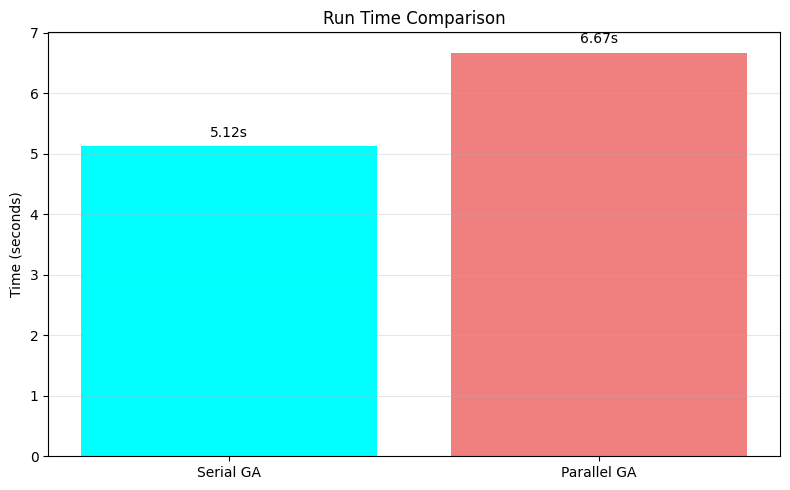

In [205]:
def plot_execution_time_comparison(serial_time, parallel_time):
    if serial_time is None or parallel_time is None:
        print("Execution times not available for plotting.")
        return
    plt.figure(figsize=(8, 5))
    methods = ['Serial GA', 'Parallel GA']
    times = [serial_time, parallel_time]
    bars = plt.bar(methods, times, color=['cyan', 'lightcoral'])
    plt.title('Run Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.grid(axis='y', alpha=0.3)
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{time_val:.2f}s', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
  plot_execution_time_comparison(serial_time, parallel_time)



In [204]:
# Stop monitoring
stop_monitoring()
monitor_thread.join()

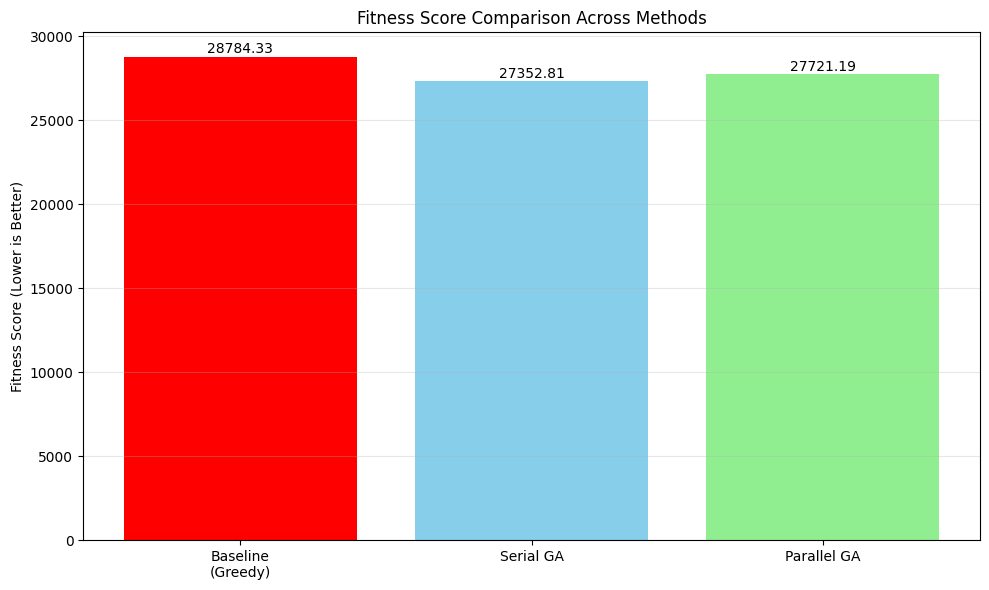

In [206]:
def compare_all_methods(baseline_fitness, serial_fitness, parallel_fitness):
    if baseline_fitness is None or serial_fitness is None or parallel_fitness is None:
         print("Fitness scores not available for comparison plotting.")
         return
    plt.figure(figsize=(10, 6))
    methods = ['Baseline\n(Greedy)', 'Serial GA', 'Parallel GA']
    fitness_scores = [baseline_fitness, serial_fitness, parallel_fitness]
    bars = plt.bar(methods, fitness_scores, color=['red', 'skyblue', 'lightgreen'])
    plt.title('Fitness Score Comparison Across Methods')
    plt.ylabel('Fitness Score (Lower is Better)')
    plt.grid(axis='y', alpha=0.3)
    for bar, score in zip(bars, fitness_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{score:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
  compare_all_methods(baseline_fitness, best_fit_serial, best_fit_parallel)


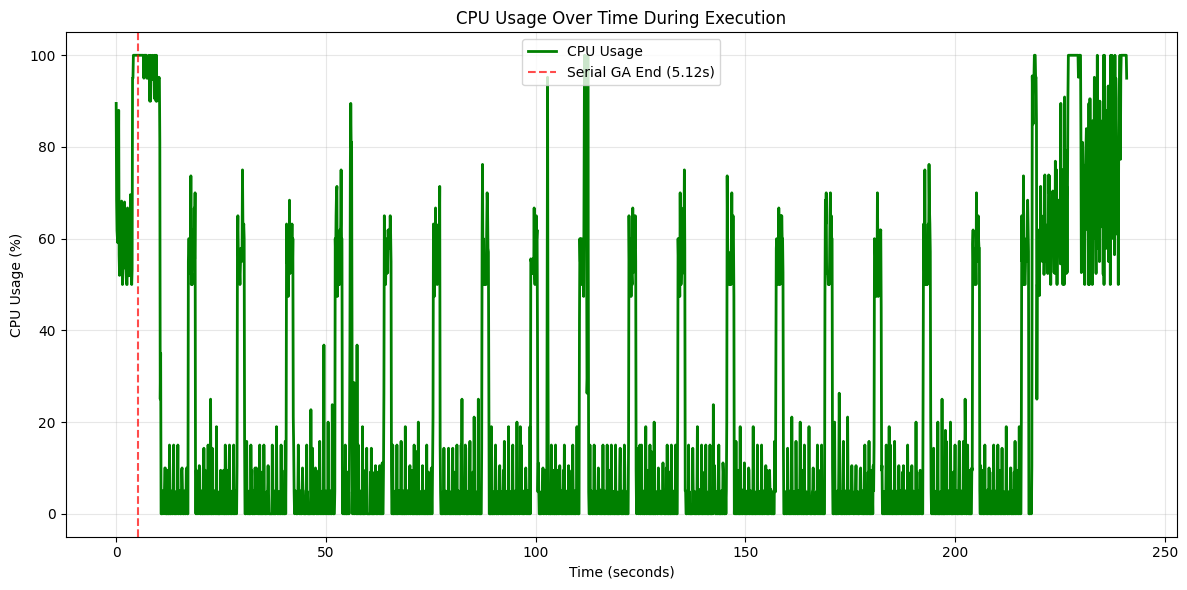

In [212]:
def plot_cpu_usage_comparison(serial_time, parallel_time):
    global cpu_usage_data_monitor, start_time_monitor

    if not cpu_usage_data_monitor:
        print("No CPU usage data collected")
        return
    if serial_time is None or parallel_time is None:
         print("Execution times not provided for CPU usage plot.")
         return

    plt.figure(figsize=(12, 6))
    # Create time axis
    time_points = np.linspace(0, len(cpu_usage_data_monitor) * 0.1, len(cpu_usage_data_monitor))
    plt.plot(time_points, cpu_usage_data_monitor, linewidth=2, color='green', label='CPU Usage')
    plt.title('CPU Usage Over Time During Execution')
    plt.xlabel('Time (seconds)')
    plt.ylabel('CPU Usage (%)')
    plt.grid(True, alpha=0.3)

    # Add vertical lines for execution periods if times are provided
    if serial_time and parallel_time:
        plt.axvline(x=serial_time, color='red', linestyle='--', alpha=0.7,
                    label=f'Serial GA End ({serial_time:.2f}s)')


    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cpu_usage_comparison(serial_time, parallel_time)